## Preparation

In [127]:
import warnings
warnings.filterwarnings("ignore")

from pprint import pprint
import re
from tqdm import tqdm

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=12, progress_bar=True)
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#!pwd
import os

# Google Bucket
# file name checkpoint_0512_sent_split.parquet
path_bucket = 'gs://msca-sp23-bucket/nlp_data'
runtime_path = '/home/anthony/projects/nlp_runtime'

os.chdir(runtime_path)
print(os.getcwd())

/home/anthony/projects/nlp_runtime


In [4]:
import pickle
bucket_read = path_bucket + '/' + 'checkpoint_0526_main_weighted_sent.parquet'
df = pd.read_parquet(bucket_read, engine='pyarrow')
df['aggregate_target_sentiment'] = df['aggregate_target_sentiment'].apply(pickle.loads)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131713 entries, 0 to 131712
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   url                         131713 non-null  object        
 1   date                        131713 non-null  datetime64[ns]
 2   article_id                  131713 non-null  int64         
 3   title                       131713 non-null  object        
 4   text                        131713 non-null  object        
 5   aggregate_target_sentiment  131713 non-null  object        
 6   sentiment                   106634 non-null  float64       
 7   month                       131713 non-null  object        
 8   top_10_entities             131713 non-null  object        
 9   top_10_entities_gpe_loc     131713 non-null  object        
 10  sent_label                  131713 non-null  object        
 11  article_topic               131713 non-

## Dataset

In [6]:
df.sample(2)

,url,date,article_id,title,text,aggregate_target_sentiment,sentiment,month,top_10_entities,top_10_entities_gpe_loc,sent_label,article_topic
15406,https://bulletinline.com/2020/09/12/global-artificial-intelligence-ai-market-forecast-revised-in-a-new-market-research-store-report-as-covid-19-projected-to-hold-a-massive-impact-on-sales-in-2020/,2020-09-12,15633,Global Artificial Intelligence (AI) Market Forecast Revised in a New Market Research Store Report as COVID-19 Projected to Hold a Massive Impact on Sales in 2020 – Bulletin Line,Global Artificial Intelligence AI Market Forecast Revised in a New Market Research Store Report as COVID 19 Projected to Hold a Massive Impact on Sales in 2020 Bulletin Line Bulletin Line Market Research Reports Home COVID 19 Industry Impact Latest Market Reports Market Price Analysis Market Study Contact Us Artificial Intelligence AI Market Forecast Revised in a New Market Research Store Report as COVID 19 Projected to Hold a Massive Impact on Sales in 2020 Global Artificial Intelligence AI...,"[(the Artificial Intelligence AI, ORG, -0.6, 6), (Market Research Store, ORG, 0.0, 3), (New Market Research Store Report, ORG, 0.13636363636363635, 2), (North America, LOC, 0.0, 1), (United States, GPE, 0.0, 1), (Canada, GPE, 0.0, 1), (Mexico, GPE, 0.0, 1), (Europe Germany, GPE, 0.0, 1), (France, GPE, 0.0, 1), (United Kingdom, GPE, 0.0, 1), (Russia, GPE, 0.0, 1), (Italy, GPE, 0.0, 1), (Asia Pacific, LOC, 0.0, 1), (China, GPE, 0.0, 1), (Japan, GPE, 0.0, 1), (Korea, GPE, 0.0, 1), (India, GPE, ...",-0.129394,2020-09,"[the Artificial Intelligence AI, Market Research Store, New Market Research Store Report]","[North America, United States, Canada, Mexico, Europe Germany, France, United Kingdom]",negative,4
131683,https://www.expressandstar.com/news/uk-news/2023/04/28/chatgpt-responses-to-patients-rated-more-empathetic-than-doctors--research/,2023-04-28,133229,ChatGPT responses to patients rated more empathetic than doctors – research | Express & Star,ChatGPT responses to patients rated more empathetic than doctors research Express Star ...MoreBook An ...Express SettingsSubscribe to one or all notification sources from this one place. to our newsletter to get the day's top stories sent directly to you.Sign Me UpNewsAll News Cost of livingLocal UK NewsViral newsFeed a FamilySponsored articlesFind news for your townChatGPT responses to patients rated more empathetic than doctors researchUK NewsPublished: 1 hour agoLast Updated: Just nowChat...,"[(Walsall, GPE, 0.0, 5), (Wolverhampton, GPE, 0.0, 5), (agoFar, PERSON, 0.0, 3), (ReadFar, ORG, 0.0, 2), (nowTeenager, PERSON, 0.0, 2), (nowWolverhampton, ORG, 0.0, 2), (Express Star, ORG, 0.0, 2), (UK NewsMost, ORG, 0.0, 1), (nowMost, ORG, 0.0, 1), (nowSorry, PERSON, 0.0, 1), (StoriesPolice, ORG, 0.0, 1), (Dudley, PERSON, 0.0, 1), (agoWolverhampton, PERSON, 0.0, 1), (77Wolverhampton, GPE, 0.0, 1), (StarVoicesPeter Rhodes, PERSON, 0.0, 1), (Peter Rhodes, PERSON, 0.0, 1), (Telford, GPE, 0.0, ...",NaN,2023-04,"[agoFar, ReadFar, nowTeenager, nowWolverhampton, Express Star, UK NewsMost, nowMost, nowSorry]","[Walsall, Wolverhampton]",neutral,0


In [81]:
'''# extract the the top 10 entities in aggregate_target_sentiment as a new column (exlucde GPE & LOC)
df['top_10_entities'] = df['aggregate_target_sentiment'].apply(lambda x: [i[0] for i in x[:10] if i[1] not in ['GPE', 'LOC']])
# extract the the top 10 entities in aggregate_target_sentiment as a new column (only include GPE & LOC)
df['top_10_entities_gpe_loc'] = df['aggregate_target_sentiment'].apply(lambda x: [i[0] for i in x[:10] if i[1] in ['GPE', 'LOC']])
# make sentiment label
df['sent_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.01 else ('negative' if x < -0.01 else 'neutral'))
# rename
df.rename(columns={'sentiment_value_weighted': 'sentiment', 'text_cleaned': 'text'}, inplace=True)
# add a month column
df['month'] = df['date'].dt.strftime('%Y-%m')
'''

In [ ]:
'''# add back topic
bucket_write = path_bucket + '/' + 'checkpoint_0526_main.parquet'
df_tmp = pd.read_parquet(bucket_write, engine='pyarrow')
df_tmp.head(1)
topic = df_tmp[['article_topic', 'article_id']]
#left join with df
df = df.merge(topic, how='left', on='article_id')
df.shape'''

In [93]:
'''# save a checkpoint
# Assuming `df` is your DataFrame and `col` is the column with the complex datatype
df['aggregate_target_sentiment'] = df['aggregate_target_sentiment'].apply(pickle.dumps)

# Then you can save the DataFrame as parquet
bucket_write = path_bucket + '/' + 'checkpoint_0526_main_weighted_sent.parquet'
df.to_parquet(bucket_write, engine='pyarrow')'''

## Q3: Top Reason and Sentiment over Time

### Counts of Publication over time

In [6]:
# convert date to YYYY-MM format
df_tmp = df[['article_id', 'month']]

# group by week to get the count of articles
df_month = df_tmp.groupby('month').agg({'article_id': 'count'}).reset_index()
df_month.head(2)

,month,article_id
0,2020-01,1819
1,2020-02,1808


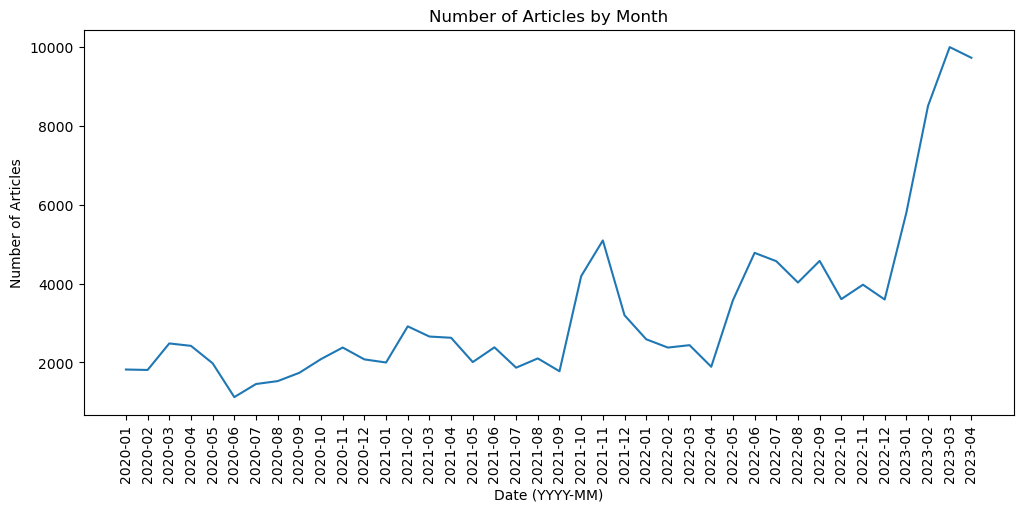

In [11]:
# use matplotlib to make a time series plot
plt.figure(figsize=(12, 5))
plt.plot(df_month['month'], df_month['article_id'])
plt.title('Number of Articles by Month')
# rotate the xticks
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.show()

### Sentiment Change overtime

In [17]:
# create a temp df
df_tmp = df[['article_id', 'month', 'sentiment']]

# groupby 'month' to calculate the average sentiment value
df_month = df_tmp.groupby('month').agg({'sentiment': 'mean'}).reset_index()
df_month.head(2)

,month,sentiment
0,2020-01,-0.008600
1,2020-02,-0.012027


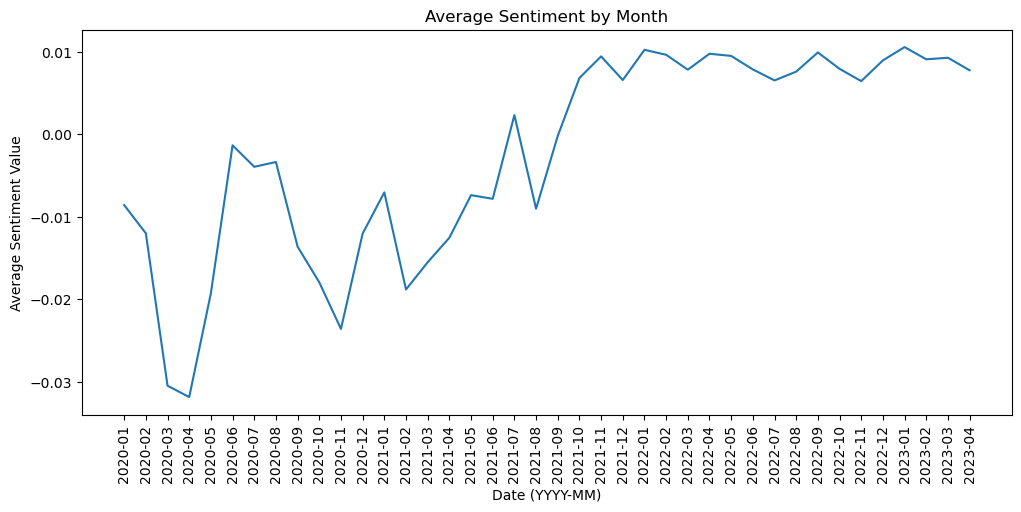

In [19]:
# use matplotlib to make a time series plot
plt.figure(figsize=(12, 5))
plt.plot(df_month['month'], df_month['sentiment'])
plt.title('Average Sentiment by Month')
# rotate the xticks
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Average Sentiment Value')
plt.xticks(rotation=90)
plt.show()

### Sentiment change over time, with scale of publications (热度)

We can combine the two plots above:
$Heatness_{monthly} = avg\_sentiment \times monthly\_publications$

In [33]:
# create a temp df
df_tmp = df[['article_id', 'month', 'sentiment']]

# groupby 'month' to calculate the average sentiment value
df_month = df_tmp.groupby('month').agg({'sentiment': 'mean', 'article_id': 'count'}).reset_index()
df_month['heatness'] = df_month['sentiment'] * df_month['article_id']
df_month.head(2)

,month,sentiment,article_id,heatness
0,2020-01,-0.008600,1819,-15.643527
1,2020-02,-0.012027,1808,-21.744824


In [34]:
heatness_df = df_month[['heatness', 'month']]

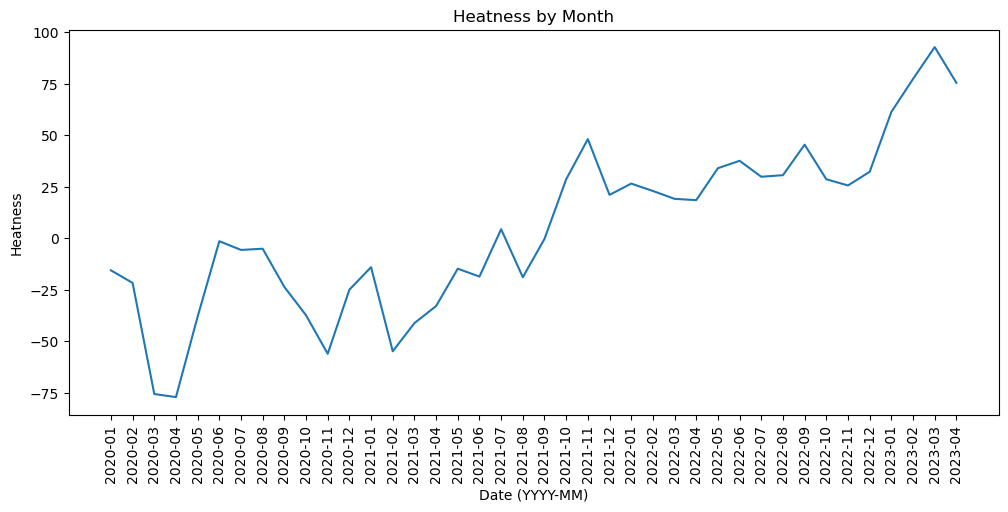

In [23]:
# use matplotlib to make a time series plot
plt.figure(figsize=(12, 5))
plt.plot(df_month['month'], df_month['heatness'])
plt.title('Heatness by Month')
# rotate the xticks
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Heatness')
plt.xticks(rotation=90)
plt.show()

### Sentiment Counts

In [28]:
# convert sentiment to label: x > 0.01 (positive), x < -0.01 (negative), -0.01 <= x <= 0.01 (neutral)
df['sent_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.01 else ('negative' if x < -0.01 else 'neutral'))
df['sent_label'].value_counts()

sent_label
neutral     86513
positive    34200
negative    11000
Name: count, dtype: int64

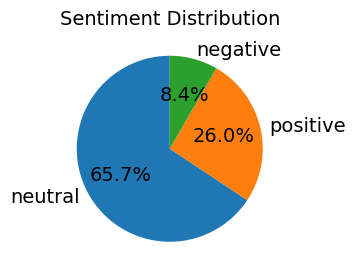

In [30]:
# make a pie chart; fontsize =14
pie = df['sent_label'].value_counts()
plt.figure(figsize=(3, 4))
plt.pie(pie, labels=pie.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.title('Sentiment Distribution', fontsize=14)
plt.show()

In [39]:
# count of sentiments over time

# create a temp df
df_tmp = df[['article_id', 'month', 'sent_label']]

# groupby 'month' and count the number of each sentiment label
df_month = df_tmp.groupby(['month', 'sent_label']).agg({'article_id': 'count'}).reset_index()

# left join with the heatness_df, key=month
df_month = df_month.merge(heatness_df, on='month', how='left')

# rename
df_month.rename(columns={'article_id': 'count'}, inplace=True)

df_month.head(2)

,month,sent_label,count,heatness
0,2020-01,negative,254,-15.643527
1,2020-01,neutral,1123,-15.643527


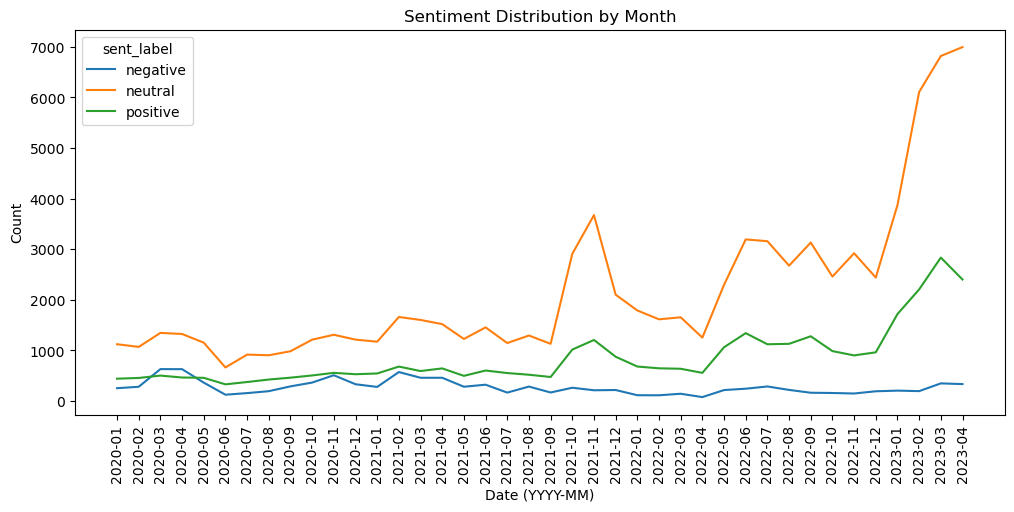

In [40]:
# make a time series plot of the count of each sentiment label
plt.figure(figsize=(12, 5))
sns.lineplot(x='month', y='count', hue='sent_label', data=df_month)
plt.title('Sentiment Distribution by Month')
# rotate the xticks
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

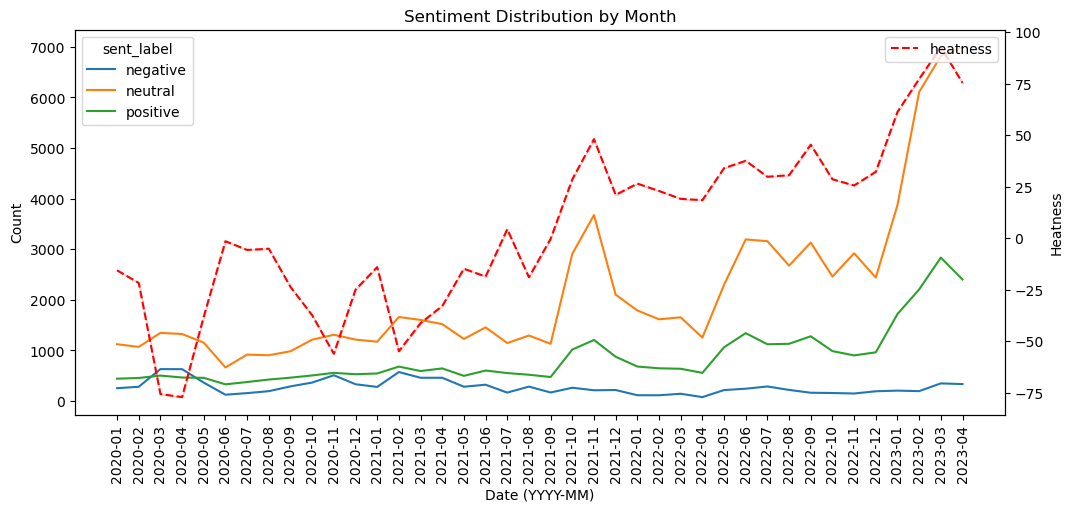

In [54]:
# make a time series plot of the count of each sentiment label
plt.figure(figsize=(12, 5))
ax1 = plt.gca() # get the current Axes instance
sns.lineplot(x='month', y='count', hue='sent_label', data=df_month, ax=ax1)
ax1.set_title('Sentiment Distribution by Month')
# rotate the xticks
ax1.set_xlabel('Date (YYYY-MM)')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=90)

# create a second y-axis
ax2 = ax1.twinx()
# plot using the second y-axis with a dashed line and labeled as 'heatness'
sns.lineplot(x='month', y='heatness', data=df_month, color='red', ax=ax2, linestyle='--', label='heatness')
ax2.set_ylabel('Heatness')  # add y-axis label

# move the legend of ax2 to the right
ax2.legend(loc='upper right')

plt.show()


### Why some succeed? Why some failed?

In [148]:
df.head(1)

,url,date,article_id,title,text,aggregate_target_sentiment,sentiment,month,top_10_entities,top_10_entities_gpe_loc,sent_label,article_topic,topic,topic_dict
0,https://theenterpriseleader.com/2020/01/01/decentralized-machine-learning-reaches-market-cap-of-15919-00-dml.html,2020-01-01,1,"Decentralized Machine Learning Reaches Market Cap of $15,919.00 (DML) - Enterprise Leader","Decentralized Machine Learning Reaches Market Cap of 15,919.00 DML Enterprise Leader Daily Ratings News for Decentralized Machine Learning Complete the form below to receive the latest headlines and analysts' mendations for Decentralized Machine Learning with our free daily email newsletter: Follow EnterpriseLeade Recent Posts GE Announces Its Plan To Sell The Distributed Power Business To Advent International Ebang Communication Resorts To The Filing Of An IPO In Hong Kong How to Open DAA, ...","[(Decentralized Machine Learning, ORG, 0.0, 11), (US, GPE, 0.0, 4), (Hong Kong, GPE, 0.0, 2), (NRG, ORG, 0.0, 2), (IMG, ORG, 0.0, 2), (Flagstar Bancorp, ORG, 0.0, 2), (IDEX, ORG, 0.0, 2), (Mistake Foxconn Launches Investigation After Reports Of Harsh Working Conditions, ORG, -0.2, 2), (Stellar XLM, ORG, 0.25, 1), (Decentralized Machine Learning Reaches Market Cap, ORG, 0.0, 1), (Wells Fargo, ORG, 0.0, 1), (Monster Beverage Corp NASDAQ, ORG, 0.0, 1), (GE, ORG, 0.0, 1), (IPO, ORG, 0.0, 1), (De...",-0.003621,2020-01,"[Decentralized Machine Learning, NRG, IMG, Flagstar Bancorp, IDEX, Mistake Foxconn Launches Investigation After Reports Of Harsh Working Conditions, Stellar XLM, Decentralized Machine Learning Reaches Market Cap]","[US, Hong Kong]",neutral,3,4,{}


In [26]:
# import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [36]:
df['article_topic'].value_counts()

article_topic
0    60872
1    25130
2    16055
3    13177
4    10774
5     2675
6     2613
7      417
Name: count, dtype: int64

In [37]:
# for convenience, add 1 to the article_topic
df['topic'] = df['article_topic'].apply(lambda x: x + 1)

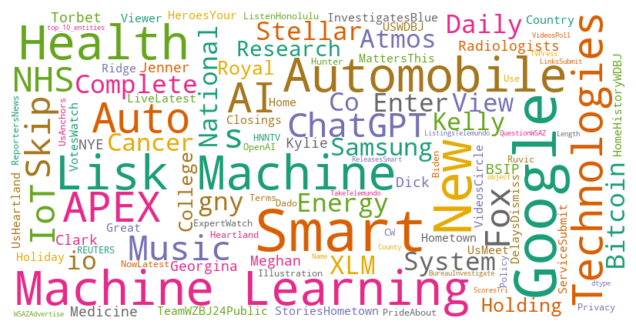

In [61]:
# filter out the articles with sentiment label as 'positive'
df_pos = df[(df['sent_label'] != 'negative') &\
            ((df['topic'] == 6) | (df['topic'] == 1))
            ]['top_10_entities']

# make a word cloud (dpi=100, figsize=(8, 8))
wordcloud = WordCloud(max_font_size=75, max_words=150, background_color="white", colormap="Dark2", width=800, height=400).generate(str(df_pos))
plt.figure(figsize=(8, 4), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
# remove the axis
plt.axis("off")
plt.show()

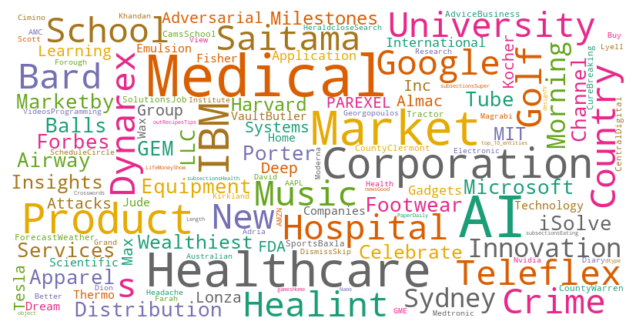

In [340]:
# filter out the articles with sentiment label as 'positive'
df_pos = df[(df['sent_label'] != 'negative') &\
            #((df['topic'] == 3) | (df['topic'] == 5))
            (df['title'].str.contains('healthcare|medical|clinical', case=False))
            ]['top_10_entities']

# make a word cloud (dpi=100, figsize=(8, 8))
wordcloud = WordCloud(max_font_size=75, max_words=150, background_color="white", colormap="Dark2", width=800, height=400).generate(str(df_pos))
plt.figure(figsize=(8, 4), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
# remove the axis
plt.axis("off")
plt.show()

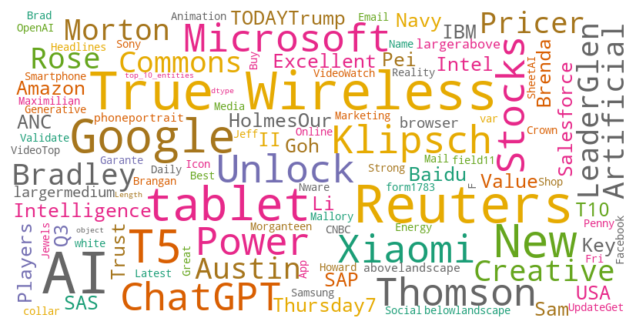

In [49]:
# filter out the articles with sentiment label as 'positive'
df_pos = df[(df['sent_label'] != 'negative') &\
            (df['topic'] == 2)
            ]['top_10_entities']

# make a word cloud (dpi=100, figsize=(8, 8))
wordcloud = WordCloud(max_font_size=75, max_words=150, background_color="white", colormap="Dark2", width=800, height=400).generate(str(df_pos))
plt.figure(figsize=(8, 4), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
# remove the axis
plt.axis("off")
plt.show()

### Articles

In [74]:
df_pos = df[(df['sent_label'] != 'negative') &\
            (df['title'].str.contains('health', case=False)) & (df['title'].str.contains('medical', case=False)) \
            ][['url', 'title', 'top_10_entities', 'sent_label']]

df_pos.sample(5)

,url,title,top_10_entities,sent_label
18452,https://eurowire.co/coronavirus/667018/north-america-artificial-intelligence-in-healthcare-diagnosis-market-size-share-demand-analysis-and-forecast-to-2027-general-electric-company-koninklijke-philips-n-v-aidoc-arterys-inc-icome-2/,"North America Artificial Intelligence in Healthcare Diagnosis Market Size, Share, Demand, Analysis and Forecast To 2027 | General Electric Company, Koninklijke Philips N.V., Aidoc, Arterys Inc., Icometrix, IDx Technologies Inc., MaxQ AI Ltd., Caption Health, Inc., Zebra Medical Vision, Inc. and Siemens Healthcare Private Limited – Eurowire","[General Electric Company, Koninklijke Philips N.V., Aidoc, Arterys Inc., Icometrix, Technologies Inc., MaxQ AI Ltd., Caption Health, Inc., Zebra Medical Vision, Inc., Siemens Healthcare Private Limited]",neutral
16041,https://thedailychronicle.in/nasa/1866165/chronic-total-occlusion-devices-market-to-2026-high-growth-opportunities-emerging-trends-industry-review-global-forecast-boston-scientific-terumo-medtronic-cardinal-health-cordis-spectra/,"Chronic Total Occlusion Devices Market To 2026 High Growth Opportunities | Emerging Trends | Industry Review | Global Forecast | Boston Scientific, Terumo, Medtronic, Cardinal Health (Cordis), Spectranetics, BARD Peripheral Vascular, Baylis Medical, Soundbite Medical – The Daily Chronicle","[Terumo, Medtronic, Cordis, Spectranetics, BARD Peripheral Vascular, Baylis Medical, Devices Major Applications/End Users Industry Are As Follows, Cordis SpectraneticsBARD Peripheral VascularBaylis MedicalSoundbite Medical, DATAINTELO]",neutral
26646,https://bisouv.com/uncategorized/1985627/suction-catheters-market-size-growth-and-key-players-medline-industries-medtronic-pennine-healthcare-bard-medical-merit-medical-systems/,"Suction Catheters Market Size, Growth And Key Players- Medline Industries, Medtronic, Pennine Healthcare, Bard Medical, Merit Medical Systems – The Bisouv Network","[Medtronic, Pennine Healthcare, Bard Medical, Merit Medical Systems, PFM Medical B Braun Smiths Medical QualiMed Innovative, Major Contributors, Mark Willams, Thrive Market Research Suction Catheters Market Analysis, ServiceChannel Fiix]",neutral
18392,https://prnewsleader.com/uncategorized/1410717/global-ai-in-medical-imaging-diagnosis-market-2020-know-the-companies-list-could-potentially-benefit-or-loose-out-from-the-impact-of-covid-19-top-companies-ge-healthcare-ibm-watson-health-phili/,"Global AI in Medical Imaging Diagnosis Market 2020 | Know the Companies List Could Potentially Benefit or Loose out From the Impact of COVID-19 | Top Companies: GE Healthcare, IBM Watson Health, Philips Healthcare, Samsung, Medtronic, etc. | InForGrowth – PRnews Leader","[GE Healthcare, IBM, The AI in Medical Imaging, IBM Watson Health, Philips Healthcare, Samsung, Medtronic, the AI in Medical Imaging, Brominated Vegetable Oil Market by Coronavirus COVID19 Impact Analysis With Top Manufacturers Analysis Top Players: Spectrum Chemical Manufacturing Corp., Parchem Fine Specialty Chemicals]",neutral
21576,https://www.mccourier.com/blockchain-for-healthcare-market-2020-2027-is-prospering-globally-leading-players-factom-medicalchain-sa-proof-works-simplyvital-health-inc-blockchain-ai-solutions-ltd/,"BLOCKCHAIN FOR HEALTHCARE MARKET 2020-2027 IS PROSPERING GLOBALLY || LEADING PLAYERS – FACTOM., MEDICALCHAIN SA., PROOF.WORKS, SIMPLYVITAL HEALTH, INC, BLOCKCHAIN AI SOLUTIONS LTD – The Courier","[INC, Healthcare, BLOCKCHAIN AI SOLUTIONS LTD, PFIZER INC, ELI LILLY, NOVARTIS AG, HETERO, PHARMACEUTICALS LTD., Healthcare Market, SAP SE]",neutral


In [76]:
df_pos = df[(df['sent_label'] != 'negative') &\
            (df['title'].str.contains('automobile|auto pilot', case=False))\
            ][['url', 'title', 'top_10_entities', 'sent_label']]

df_pos.sample(5)

,url,title,top_10_entities,sent_label
5706,https://3wnews.org/uncategorised/417086/machine-learning-in-automobile-market-size-share-growth-demand-trends-forecast-to-2020-2024/,"Machine Learning in Automobile Market Size, Share, Growth, Demand, Trends, Forecast To 2020-2024 – 3rd Watch News","[the Machine Learning in Automobile, Machine Learning in Automobile, Global Machine Learning in Automobile, Machine Learning in Automobile Market Size, Allerin Intellias Ltd, Xevo Kopernikus, Automotive Blippar Alphabet Inc Intel, IBM]",neutral
20212,https://eurowire.co/news/1388353/machine-learning-in-automobile-market-with-competitive-analysis-new-business-developments-and-top-companies/,"Machine Learning in Automobile Market with Competitive Analysis, New Business Developments and Top Companies: – Eurowire","[Machine Learning in Automobile Industry, the Machine Learning in Automobile Industry, NVIDIA Corporation, Xevo, Kopernikus Automotive, Blippar, Alphabet Inc, Intel, IBM, Microsoft, Grand View Report]",positive
3884,https://nysenewstimes.com/machine-learning-in-automobile-market-global-trends-drivers-strategies-applications-and-competitive-landscape-2025/,"Machine Learning in Automobile Market Global Trends, Drivers, Strategies, Applications And Competitive Landscape 2025 – Nyse News Times","[Machine Learning in Automobile, the Machine Learning in Automobile, Nyse News Times, The Machine Learning in Automobile, the Worldwide Machine Learning in Automobile, the Machine Learning, Loyalty Management Market Global Industry Analysis, Emerging Ceramic Armor Market]",neutral
40827,https://www.aninews.in/news/business/business/fairfirst-insurance-announces-partnership-with-camcom-to-harness-ai-powered-automobile-inspection-solutions20210823162755/,Fairfirst Insurance announces partnership with CamCom to harness AI powered automobile inspection solutions,"[ANI, Fairfirst, Fairfirst Insurance, Eduten, HCL]",neutral
7306,https://www.njmmanews.com/machine-learning-in-automobile-market-covid-19-updated-tremendous-growth-by-allerin-intellias-ltd-nvidia-corporation-xevo-kopernikus-automotive/,"Machine Learning in Automobile Market (COVID-19 UPDATED) Tremendous Growth by: Allerin, Intellias Ltd, NVIDIA Corporation, Xevo, Kopernikus Automotive – NJ MMA News","[Machine Learning in Automobile Market, NVIDIA Corporation, Xevo, the Machine Learning in Automobile Market, Ignite Ltd, Yodlee, Trill A.I., IBM, Microsoft]",neutral


## Q4: Occurance of new technologies

### Frequent entities
See if we can find some valuable information from top_10_entitites

In [112]:
# filter out the articles with sentiment label as 'positive'
df_pos = df[(df['sent_label'] != 'negative')]['top_10_entities']

# for each row, take the top 10 entities convert to a list of unique elements
pos_entities = df_pos.apply(lambda x: list(set(x))).tolist()

In [105]:
from collections import Counter
# count and sort by the frequency of each entity; using collections.Counter
pos_entities_freq = Counter([item for sublist in pos_entities for item in sublist]).most_common(1000)

# filter the results
# remove the entities that has more than 5 wrods
pos_entities_freq = [x for x in pos_entities_freq if len(x[0].split()) <= 5]

# remove the entities that are in the stop_words list (should not contrain any stop words)
stop_words = ['Apple', 'AI', 'Google', 'IBM', 'Nvidia', 'Amazon', 'OpenAI', 'Microsoft', 'Intel', 'Facebook', 'Tesla', 'AWS', 'Digital',
              'Elon Musk', 'EU', 'Meta', 'Netflix', 'Baidu', 'Samsung', 'Biden']
exclude_words = ['Music', 'Entertain', 'BureauInvestigate', 'NewscastsPress', 'WDPN', 'Press', 'Weather Channel', 'TV', 'National',
                 'Closings']

# (should not contrain any stop words)
pos_entities_freq_filtered = []
for entity in pos_entities_freq:
    if entity[0] not in stop_words: # search for exclude_words
        match = [word for word in exclude_words if word in entity[0]]
        if len(match) == 0:
            pos_entities_freq_filtered.append(entity)

In [106]:
pos_entities_freq_filtered[:25]

[('ChatGPT', 5924),
 ('Twitter', 1520),
 ('GPT', 1199),
 ('Machine Learning', 1192),
 ('Bard', 1171),
 ('ML', 1084),
 ('GPU', 842),
 ('Android', 805),
 ('NLP', 799),
 ('Data Science', 796),
 ('CalendarWhat', 774),
 ('Roku', 772),
 ('Reuters', 766),
 ('Musk', 747),
 ('Healthcare', 746),
 ('TikTok', 737),
 ('iPhone', 732),
 ('MapSubmit', 729),
 ('DelaysDismiss', 724),
 ('NASA', 712),
 ('UsMeet', 710),
 ('FDA', 703),
 ('Artificial Intelligence', 700),
 ('Instagram', 686),
 ('EIN', 662)]

### Match Topic and Time

In [254]:
# we have a list to hot topics of technology since 2020-01
ai_topics = [
    "GPT3",
    "GPT4",
    "ChatGPT",
    "DeepMind",
    "BERT",
    "Bard",
    "Explainable AI",
    "Generative AI",
    "Chatbots",
    "Edge AI",
    "Quantum computing and AI"
    "Transformer",
    "Deep learning",
    "Transfer learning",
    "AutoML",
    "Autonomous Locomotives",
    "Convolutional neural networks",
    "Recurrent neural networks",
    "Bayesian machine learning",
    "Semi-supervised learning",
    "Generative adversarial networks",
    "Federated learning",
    "Meta-learning",
    # patch
    "Graph Neural Networks",
    "Zero-shot learning",
    "Stable diffusion",
    "Multi-modal models",
    "Multimodal learning",
    "Causal inference",
    'AIOps',
    "Synthetic Biology",
    "Adaptive Learning Systems",
    "MuZero",
    "DALL-E",
    "DALLE",
    "YOLOv4", "YOLO4",
    "YOLOv5", "YOLO5",
    "EfficientNet",
    "CLIP",
    "Contrastive Language Image Pretraining"
]

# convert both to lower case
ai_topics = [x.lower() for x in ai_topics]

In [255]:
# import pickle
# bucket_read = path_bucket + '/' + 'checkpoint_0526_main_weighted_sent.parquet'
# df = pd.read_parquet(bucket_read, engine='pyarrow')
# df['aggregate_target_sentiment'] = df['aggregate_target_sentiment'].apply(pickle.loads)

In [256]:
# test = df.sample(10)[['title', 'top_10_entities', 'month', 'article_id', 'text']]
# test[['title', 'text']]

In [257]:
# List of topics
topics_all = ai_topics

# helper function to match the topic
def match_topic(row, topics):
    '''Create an empty dictionary to store the topics and their corresponding months
    Take in a row of the dataframe, and a list of topics
    For each topic, loop over the title and top_10_entities columns to see if the topic name is in the title or top_10_entities (ignore case)
    If matched, append the month to matched_months; then append the key (topic) and the value (matched_months) to topic_dict
    '''
    topic_dict = {}
    matched_months = []
    for topic in topics:
        top10_entities = [x.lower() for x in row['top_10_entities'].tolist()]
        if (topic in top10_entities) or (topic in row['text'].lower()):
            matched_months.append(row['month'])
            topic_dict[topic] = matched_months
    return topic_dict

In [258]:
# parallel_apply to df

#test['topic_dict'] = test.parallel_apply(lambda x: match_topic(x, topics_all), axis=1)
topic_dict_all = df.parallel_apply(lambda x: match_topic(x, topics_all), axis=1)

In [259]:
print(len(topic_dict_all))
topic_dict_all.sample(5)

131713


117484                       {'chatgpt': ['2023-03', '2023-03', '2023-03'], 'generative ai': ['2023-03', '2023-03', '2023-03'], 'chatbots': ['2023-03', '2023-03', '2023-03']}
117380                                                                                                                                                                      {}
75344     {'bert': ['2022-07', '2022-07', '2022-07'], 'explainable ai': ['2022-07', '2022-07', '2022-07'], 'convolutional neural networks': ['2022-07', '2022-07', '2022-07']}
56235                                                                                                                                                {'deepmind': ['2022-01']}
64936                                                                                                                                                                       {}
dtype: object

Next, we want to make a dataframe of topic keyword and their earliest mentioned time
1. In each row at `topic_dict_all`, iterate over all keys and only keep the earliest date in that value (a list of dates)
2. Merge all rows based on keys, and append their dates into a same list
3. Perform the step 1 again to get earliest date
4. Convert to df

In [260]:
# step 1
def dict_sort_date(topic_dict):
    '''Take in a dictionary of topics and their corresponding months
    Sort the months for each topic; keep the earliest month as the first element
    Return a dictionary of topics and their corresponding earliset
    '''
    sorted_dict = topic_dict.copy()
    for key, value in sorted_dict.items():
        sorted_dict[key] = sorted(value)[0]
    return sorted_dict

# test = {'bert': ['2022-11', '2022-01'], 'virtual assistants': ['2022-11', '2022-11']}
# test_sorted = dict_sort_date(test)

In [261]:
# apply to the topic_dict_all
topic_dict_all_sorted = topic_dict_all.parallel_apply(dict_sort_date)

In [262]:
topic_dict_all_sorted.shape

(131713,)

In [263]:
from collections import defaultdict

# Initialize defaultdict with list as the default factory
topic_dict_merged = defaultdict(list)

# Iterate over dictionaries in each row
for d in topic_dict_all_sorted:
    for key, value in d.items():
        # Append each value to the appropriate list
        topic_dict_merged[key].append(value)

# Convert back to a regular dictionary (if necessary)
topic_dict_merged = dict(topic_dict_merged)

In [264]:
# step 3
topic_dict_merged_sorted = dict_sort_date(topic_dict_merged)
topic_dict_merged_sorted

{'bert': '2020-01',
 'chatbots': '2020-01',
 'deep learning': '2020-01',
 'deepmind': '2020-01',
 'bard': '2020-01',
 'clip': '2020-01',
 'generative adversarial networks': '2020-01',
 'federated learning': '2020-01',
 'multimodal learning': '2020-01',
 'edge ai': '2020-01',
 'explainable ai': '2020-01',
 'automl': '2020-01',
 'efficientnet': '2020-01',
 'recurrent neural networks': '2020-01',
 'generative ai': '2020-01',
 'transfer learning': '2020-01',
 'convolutional neural networks': '2020-01',
 'aiops': '2020-01',
 'dalle': '2020-01',
 'synthetic biology': '2020-02',
 'causal inference': '2020-02',
 'graph neural networks': '2020-02',
 'adaptive learning systems': '2020-03',
 'muzero': '2020-03',
 'bayesian machine learning': '2020-05',
 'gpt3': '2020-07',
 'yolov4': '2021-04',
 'yolov5': '2021-10',
 'stable diffusion': '2022-08',
 'chatgpt': '2022-12',
 'contrastive language image pretraining': '2022-12',
 'gpt4': '2022-12'}

In [265]:
# step 4: convert to dataframe
topic_occurence_df = pd.DataFrame.from_dict(topic_dict_merged_sorted, orient='index', columns=['earliest_month'])
# reset index. new column is called 'topic'
topic_occurence_df.reset_index(inplace=True)
topic_occurence_df.rename(columns={'index': 'topic'}, inplace=True)
topic_occurence_df.head()

,topic,earliest_month
0,bert,2020-01
1,chatbots,2020-01
2,deep learning,2020-01
3,deepmind,2020-01
4,bard,2020-01


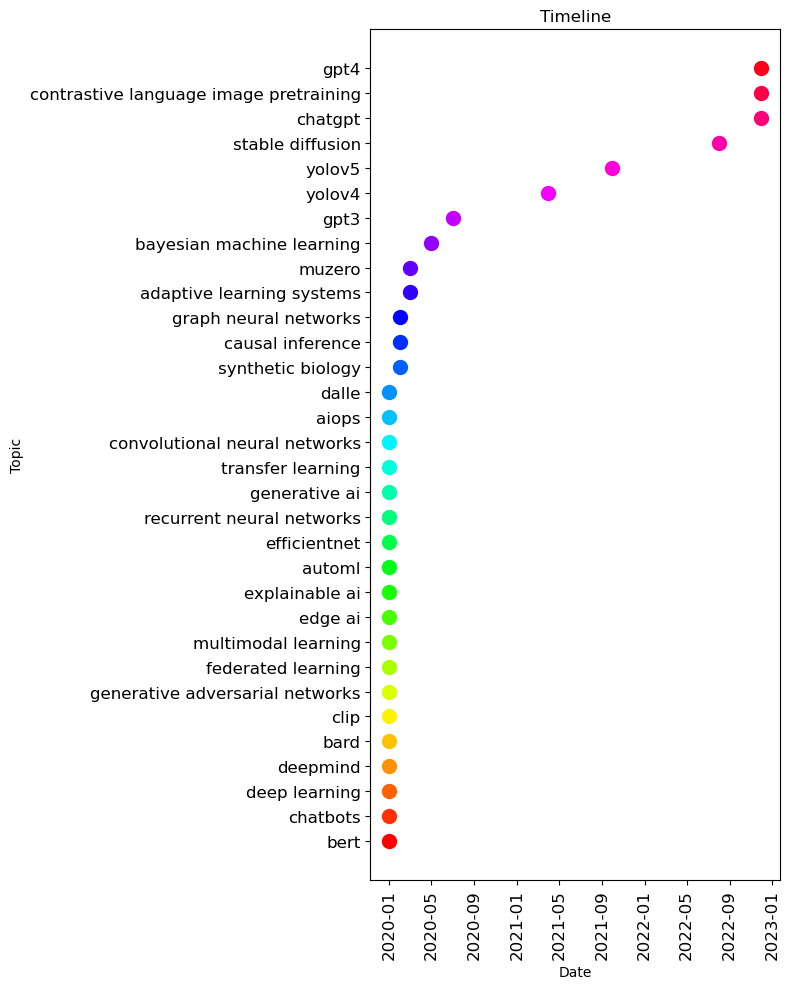

In [269]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import date2num
import datetime

df_tmp = topic_occurence_df.copy()

# Let's convert 'earliest_month' from string to datetime format
df_tmp['earliest_month'] = pd.to_datetime(df_tmp['earliest_month'])

# Convert dates to numbers
df_tmp['date_num'] = date2num(df_tmp['earliest_month'])

# Create a color list, one color per distinct topic
topics = df_tmp['topic'].unique()
colors = plt.cm.get_cmap('hsv', len(topics))

# Create the plot (figsize (6,10))
fig, ax = plt.subplots(figsize=(8,10))

# Loop through the dataframe and plot each topic as a dot on the plot
for i, topic in enumerate(topics):
    topic_data = df_tmp[df_tmp['topic'] == topic]
    ax.scatter(x=topic_data['date_num'], y=topic_data['topic'], color=colors(i), s=100)

# Set the x-axis as dates
# Font size should be 14
ax.xaxis_date()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('Timeline')
plt.xlabel('Date')
plt.ylabel('Topic')
# rotate the x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import date2num
import datetime

df_tmp = topic_occurence_df.copy()

# Let's convert 'earliest_month' from string to datetime format
df_tmp['earliest_month'] = pd.to_datetime(df_tmp['earliest_month'])

# Convert dates to numbers
df_tmp['date_num'] = date2num(df_tmp['earliest_month'])

# Create a color list, one color per distinct topic
topics = df_tmp['topic'].unique()
colors = plt.cm.get_cmap('hsv', len(topics))

# Create the plot (figsize (6,10))
fig, ax = plt.subplots(figsize=(8,10))

# Loop through the dataframe and plot each topic as a dot on the plot
for i, topic in enumerate(topics):
    topic_data = df_tmp[df_tmp['topic'] == topic]
    # Swap x and y
    ax.scatter(y=topic_data['date_num'], x=topic_data['topic'], color=colors(i), s=100)

# Set the y-axis as dates (instead of x-axis)
ax.yaxis_date()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.title('Timeline')
plt.ylabel('Date') # Swapping x and y labels
plt.xlabel('Topic')

plt.tight_layout()
plt.show()


## Q5: NER & Target Sentiment

### Explolration

In [273]:
df.sample(1)

,url,date,article_id,title,text,aggregate_target_sentiment,sentiment,month,top_10_entities,top_10_entities_gpe_loc,sent_label,article_topic
16810,https://primefeed.in/news/5277027/healthcare-artificial-intelligence-market-report-history-and-forecast-2016-2027-breakdown-data-by-manufacturers-key-regions-types-and-application/,2020-10-08,17064,"Healthcare Artificial Intelligence Market Report, History and Forecast 2016-2027, Breakdown Data by Manufacturers, Key Regions, Types and Application – Owned","Healthcare Artificial Intelligence Market Report, History and Forecast 2016 2027, Breakdown Data by Manufacturers, Key Regions, Types and Application Owned Skip to the content Healthcare Artificial Intelligence Market Report, History and Forecast 2016 2027, Breakdown Data by Manufacturers, Key Regions, Types and Application Overview The report on the Global Healthcare Artificial Intelligence Market growth provides prehensive analysis of the Healthcare Artificial Intelligence industry includ...","[(the Healthcare Artificial Intelligence Market, ORG, -0.6, 4), (Healthcare Artificial Intelligence, ORG, -0.6, 3), (Breakdown Data, ORG, 0.0, 2), (Healthcare Artificial Intelligence Market, ORG, -0.6, 2), (the Healthcare Artificial Intelligence, ORG, -0.6, 2), (Healthcare Artificial Intelligence Market Report, ORG, -0.6, 2), (International Business Smart Software, ORG, 0.10714285714285714, 1), (IBM Corporation Microsoft Corporation Google Inc., ORG, 0.0, 1), (Intel Corporation, ORG, 0.0, 1)...",-0.370207,2020-10,"[the Healthcare Artificial Intelligence Market, Healthcare Artificial Intelligence, Breakdown Data, Healthcare Artificial Intelligence Market, the Healthcare Artificial Intelligence, Healthcare Artificial Intelligence Market Report, International Business Smart Software, IBM Corporation Microsoft Corporation Google Inc., Intel Corporation, GE Healthcare CloudMedX, Inc.]",[],negative,3


In [271]:
# get the len of list for column 'aggregate_target_sentiment'
target_entity_len = df['aggregate_target_sentiment'].parallel_apply(lambda x: len(x))

In [272]:
target_entity_len.describe()

count    131713.000000
mean         36.898066
std          40.316388
min           0.000000
25%          14.000000
50%          26.000000
75%          48.000000
max         810.000000
Name: aggregate_target_sentiment, dtype: float64

Now we want to merge the target_entities_sentiments:
- Each entity in each row looks like `(the Healthcare Artificial Intelligence, ORG, -0.6, 2)`
    - `-0.6` is the average target sentiment polarity in this article; `2` is the number of occurance
- Each row has unique tuples of entities

The steps will be:
1. Before merging, we need to filter the entities
    - In common senses, the topic of an aritcle should be mentioned more than once
2. Then, define a function that takes in a list of tuples and returns a dict includes all entities:
    - key is (name, label)
    - value is a list of 2 elements: [occurance, cumulative_sent_polarity]
    - demo: give a new tuple (Name, Label, avg_polarity, occurence) as input, extract (Name, Label) & avg_polarity
    - if is a new key: (Name, Label), the func add it to dict
    - if the key exists, then occurence+=1, cumulative_sent_polarity += polarity


In [ ]:
# step 1: filter entities in 'aggregate_target_sentiment' with occurence less than 2

def filter_target_entity(row):
    '''Take in a row of the dataframe -> a list of tuples like (the Healthcare Artificial Intelligence, ORG, -0.6, 2)
    Filter the entities in 'aggregate_target_sentiment' with occurence less than 2
    Return a list of entities
    '''
    filtered_list = []
    for entity in row['aggregate_target_sentiment']:
        if entity[3] > 1:
            filtered_list.append(entity)
    return filtered_list

# test = df.sample(20)
# test['filtered_target_entity'] = test.parallel_apply(filter_target_entity, axis=1)
# test[['aggregate_target_sentiment', 'filtered_target_entity']].head(2)

In [277]:
# apply to df
df['filtered_target_entity'] = df.parallel_apply(filter_target_entity, axis=1)

In [279]:
# append all rows into one list
filtered_target_entity_list = []
for row in df['filtered_target_entity']:
    filtered_target_entity_list.extend(row)

In [281]:
#len(filtered_target_entity_list)

764062

In [282]:
# step 2: merge tuples with the same entity (name,label)

def target_entity_merge(entity_list):
    '''
    Takes in a list of tuples. Each tuple has the format (name, label, sentiment, occurence)
    Process: 
        - create a dictionary (key = (name, label), value = (cumulative_sentiment, frequency))
        - iterate the list, for each tuple, extract the key; remember that we don't need the occurence from the tuple
        - if the key is new, add it to the dictionary, cumulative_sentiment = sentiment, frequency = 1
            - if the key is already in the dictionary, update the cumulative_sentiment and frequency (+=1)
    Returns a dictionary (key = (name, label), value = (cumulative_sentiment, occurence))
    '''
    entity_dict = {}
    for entity in entity_list:
        key = (entity[0], entity[1])
        if key not in entity_dict:
            entity_dict[key] = (entity[2], 1)
        else:
            entity_dict[key] = (entity_dict[key][0] + entity[2], entity_dict[key][1] + 1)
    return entity_dict

In [283]:
%%time
# apply to filtered_target_entity_list
target_entity_results = target_entity_merge(filtered_target_entity_list)

CPU times: user 745 ms, sys: 30.6 ms, total: 775 ms
Wall time: 774 ms


In [290]:
# make a dataframe from the dictionary: columns = ['name', 'label', 'cumulative_sentiment', 'frequency']
target_entity_df = pd.DataFrame.from_dict(target_entity_results, orient='index', columns=['cumulative_sentiment', 'frequency'])
target_entity_df.reset_index(inplace=True)
target_entity_df.rename(columns={'index': 'entity_pair'}, inplace=True)
target_entity_df.head(2)

,entity_pair,cumulative_sentiment,frequency
0,"(Decentralized Machine Learning, ORG)",0.0,308
1,"(US, GPE)",0.0,11370


In [291]:
# break the entity_pair into two columns: name and label
target_entity_df[['name', 'label']] = pd.DataFrame(target_entity_df['entity_pair'].tolist(), index=target_entity_df.index)
target_entity_df.drop(columns=['entity_pair'], inplace=True)
# change the order of columns
target_entity_df = target_entity_df[['name', 'label', 'cumulative_sentiment', 'frequency']]
target_entity_df.head(2)

,name,label,cumulative_sentiment,frequency
0,Decentralized Machine Learning,ORG,0.0,308
1,US,GPE,0.0,11370


In [293]:
# sort by frequency
target_entity_df.sort_values(by=['frequency'], ascending=False, inplace=True)
target_entity_df.head(10)

,name,label,cumulative_sentiment,frequency
14,AI,ORG,0.0,28614
1,US,GPE,0.0,11370
20,Google,ORG,0.0,9418
202,Microsoft,ORG,0.0,8924
176,India,GPE,0.0,8588
173,China,GPE,0.0,6455
17,U.S.,GPE,0.0,6200
201,IBM,ORG,0.0,5413
151471,ChatGPT,ORG,0.0,5109
19,UK,GPE,0.0,3971


In [295]:
# sort by cumulative_sentiment
target_entity_df.sort_values(by=['cumulative_sentiment'], ascending=False, inplace=True)

# Filter GPE and LOC out
target_entity_df_tmp = target_entity_df[(target_entity_df['label'] != 'GPE') & (target_entity_df['label'] != 'LOC')]
target_entity_df_tmp.head(10)

,name,label,cumulative_sentiment,frequency
1628,TechRepublic Academy Best VPN Services,ORG,92.000000,92
145402,Best Samsung,ORG,71.000000,71
4206,Fair Isaac Corporation,ORG,68.600000,98
50646,Gartner Cool Vendor,ORG,43.750000,125
114508,Intelligent Cloud Platform to,ORG,35.200000,44
118706,Intelligent Vision Sensor IMX500,ORG,35.200000,44
152185,Franc CHF New Zealand,ORG,33.818182,248
118008,Best Security Orchestration,ORG,33.000000,33
38567,Search Advanced,ORG,32.400000,81
5484,The New York Times,ORG,32.045455,235


In [ ]:
# calculate avg_sentiment_per_article: cumulative_sentiment / frequency
target_entity_df['avg_sentiment_per_article'] = target_entity_df['cumulative_sentiment'] / target_entity_df['frequency']

It's pretty clear many of high sentiment entities are of advertisement. Let's fix it.

In [315]:
target_entity_df['frequency'].describe()

count    178476.000000
mean          4.281035
std          93.594199
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       28614.000000
Name: frequency, dtype: float64

<Axes: xlabel='frequency', ylabel='Density'>

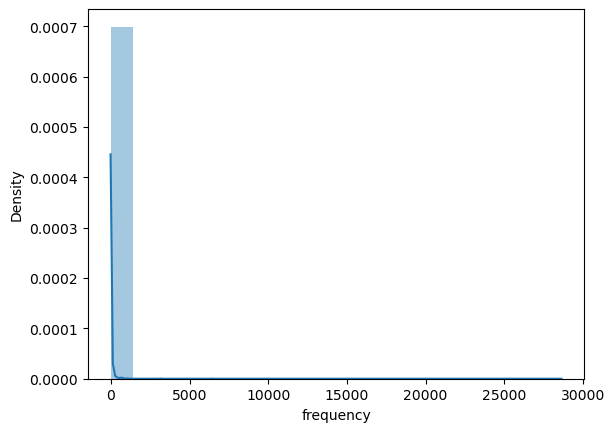

In [316]:
# extract the column 'cumulative_sentiment' and plot the frequency 
# use sns distplot
frequency = target_entity_df['frequency']
sns.distplot(frequency, bins=20, kde=True, rug=False)

That is because most of entities are not hot topics. But we can filter them out!

<Axes: xlabel='frequency', ylabel='Density'>

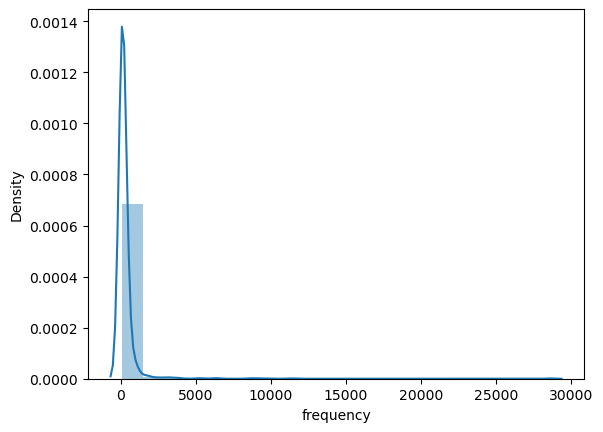

In [334]:
# filter and keep frequency > 100
target_entity_df_filtered = target_entity_df[target_entity_df['frequency'] > 50]

frequency = target_entity_df_filtered['frequency']
sns.distplot(frequency, bins=20, kde=True, rug=False)

In [335]:
# what the most frequent entity?
target_entity_df_filtered.sort_values(by=['frequency'], ascending=False, inplace=True)
target_entity_df_filtered.head(10)

,name,label,cumulative_sentiment,frequency,avg_sent_per_article
14,AI,ORG,0.0,28614,0.0
1,US,GPE,0.0,11370,0.0
20,Google,ORG,0.0,9418,0.0
202,Microsoft,ORG,0.0,8924,0.0
176,India,GPE,0.0,8588,0.0
173,China,GPE,0.0,6455,0.0
17,U.S.,GPE,0.0,6200,0.0
201,IBM,ORG,0.0,5413,0.0
151471,ChatGPT,ORG,0.0,5109,0.0
19,UK,GPE,0.0,3971,0.0


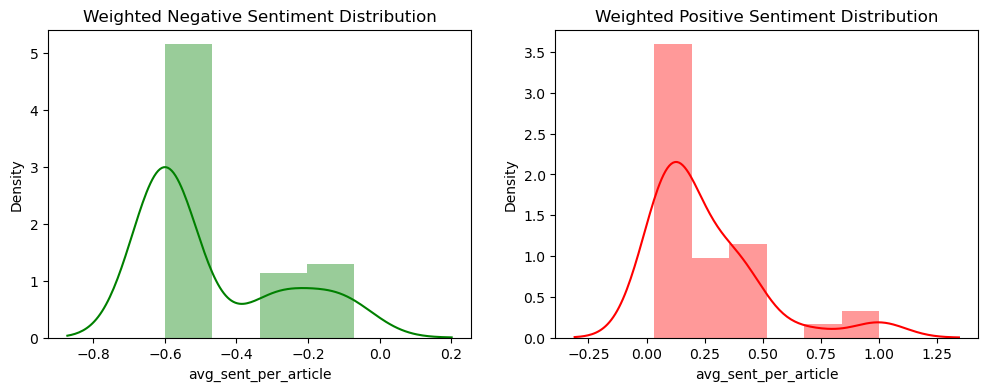

In [336]:
# extract the column 'cumulative_sentiment' and plot the frequency 

sent_values = target_entity_df_filtered['avg_sent_per_article']
negative_values, positive_values = sent_values[sent_values < 0], sent_values[sent_values > 0]

# plot the distribution of sentiment_value (positive & negative), with subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(negative_values, ax=ax[0], color='green')
sns.distplot(positive_values, ax=ax[1], color='red')
ax[0].set_title('Weighted Negative Sentiment Distribution')
ax[1].set_title('Weighted Positive Sentiment Distribution')
plt.show()

In [337]:
# find the botton 10 entities with cumulative_sentiment and frequency
# sort avg_sent_per_article in acsending order, but sort frequency in descending order
target_entity_df_filtered.sort_values(by=['avg_sent_per_article', 'frequency'], ascending=[True, False], inplace=True)
target_entity_df_filtered.head(15)

,name,label,cumulative_sentiment,frequency,avg_sent_per_article
15,Artificial Intelligence AI,ORG,-1003.8,1673,-0.6
329,the Artificial Intelligence AI,ORG,-478.8,798,-0.6
315,the Artificial Intelligence,ORG,-391.2,652,-0.6
6197,Automotive Artificial Intelligence,ORG,-63.6,106,-0.6
560,Artificial Intelligence Platform,ORG,-55.2,92,-0.6
3092,the Artificial Intelligence Software,ORG,-51.6,86,-0.6
3717,Automotive Artificial Intelligence Market,ORG,-50.4,84,-0.6
5655,Artificial Intelligence Software Market,ORG,-49.8,83,-0.6
3236,Artificial Intelligence and Machine Learning,ORG,-46.8,78,-0.6
16013,Artificial Intelligence Technology Opportunities Fund,ORG,-46.8,78,-0.6


In [338]:
# remove columns that contain 'Artificial Intelligence AI' or 'the Artificial Intelligence'
target_entity_df_filtered_2 = target_entity_df_filtered[~target_entity_df_filtered['name'].str.contains('Artificial Intelligence AI|the Artificial Intelligence|Black', case=False)]


# filter out GPE
target_entity_df_filtered_2 = target_entity_df_filtered_2[(target_entity_df_filtered_2['label'] != 'GPE') & (target_entity_df_filtered_2['label'] != 'LOC')]

# sort and see the results
target_entity_df_filtered_2.sort_values(by=['avg_sent_per_article', 'frequency'], ascending=[True, False], inplace=True)
target_entity_df_filtered_2.head(15)

,name,label,cumulative_sentiment,frequency,avg_sent_per_article
6197,Automotive Artificial Intelligence,ORG,-63.6,106,-0.6
560,Artificial Intelligence Platform,ORG,-55.2,92,-0.6
3717,Automotive Artificial Intelligence Market,ORG,-50.4,84,-0.6
5655,Artificial Intelligence Software Market,ORG,-49.8,83,-0.6
3236,Artificial Intelligence and Machine Learning,ORG,-46.8,78,-0.6
16013,Artificial Intelligence Technology Opportunities Fund,ORG,-46.8,78,-0.6
2039,Artificial Intelligence in,ORG,-42.6,71,-0.6
6960,Artificial Intelligence Software System,ORG,-41.4,69,-0.6
6315,Artificial Intelligence in Aviation,ORG,-39.0,65,-0.6
6194,the Automotive Artificial Intelligence,ORG,-39.0,65,-0.6


We only care about technologies. Let's remove some rows.

### What types of companies (or industry?) should invest in AI (successful stories)

In [339]:
target_entity_df_filtered_2.sort_values(by=['avg_sent_per_article', 'frequency'], ascending=[False, False], inplace=True)
target_entity_df_filtered_2.head(15)

,name,label,cumulative_sentiment,frequency,avg_sent_per_article
1628,TechRepublic Academy Best VPN Services,ORG,92.000000,92,1.000000
145402,Best Samsung,ORG,71.000000,71,1.000000
4206,Fair Isaac Corporation,ORG,68.600000,98,0.700000
14329,Forest Products Containers Precious Metals Textiles Tobacco,ORG,26.000000,52,0.500000
13333,Advanced Micro Devices,ORG,21.600000,54,0.400000
114302,Advanced Machine Learning Application,ORG,22.800000,57,0.400000
121834,Free Apps WFMZ TV,ORG,26.400000,66,0.400000
5734,Witness Huge Growth,ORG,32.000000,80,0.400000
38567,Search Advanced,ORG,32.400000,81,0.400000
6510,Thoughtful Systems,ORG,32.000000,80,0.400000


### What types of applications cannot be transformed by AI?